I’ve been struggling for a while with 3D rotations, which are very important tool for many applications in physics. In this notebook, we will go on a short tour about Euler angles and in particular, the Bunge convention.

Our goal with this post will be to replicate an animation from Wikipedia:

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c5/Euler2.gif"/>

To me, this an interesting image because it features a rotating coordinate system and a 3D object that changes its orientation based on rotation about several axes. 

How can we approach this problem? The ingredients we will need are:

- rotation matrices
- change of basis formulas
- 3D meshing capabilities

Let’s dive in.

# Rotation matrices and the change of basis formula 

## Starting with a Z-rotation 

One of the simplest ways to approach rotations in 3D is through the description of a rotating system around the z-axis.

The starting frame is x-y-z and it becomes, through a rotation of angle $\theta$, the frame x’-y’-z.

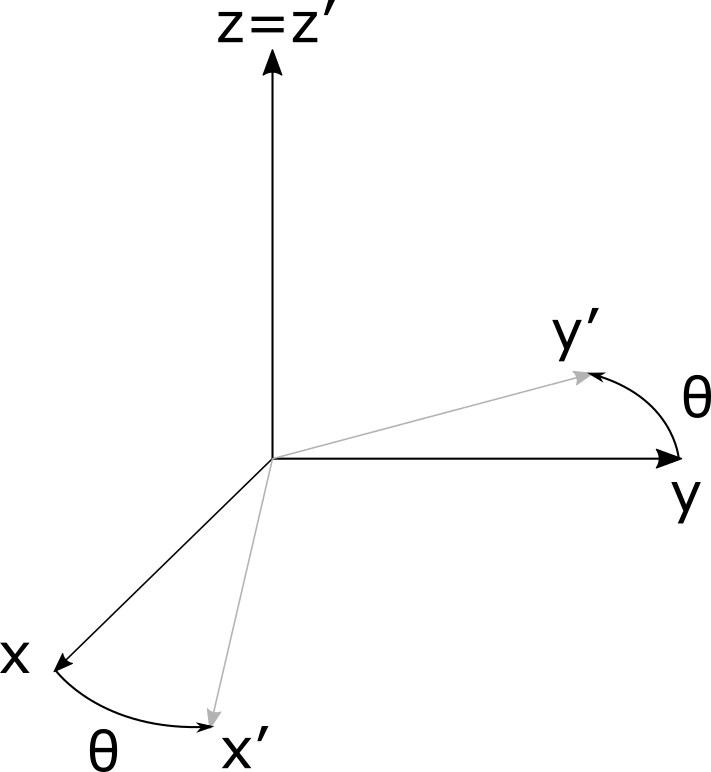

A second drawing makes it easy, using trigonometry, to describe the relationship between the rotated basis vectors and the old ones:

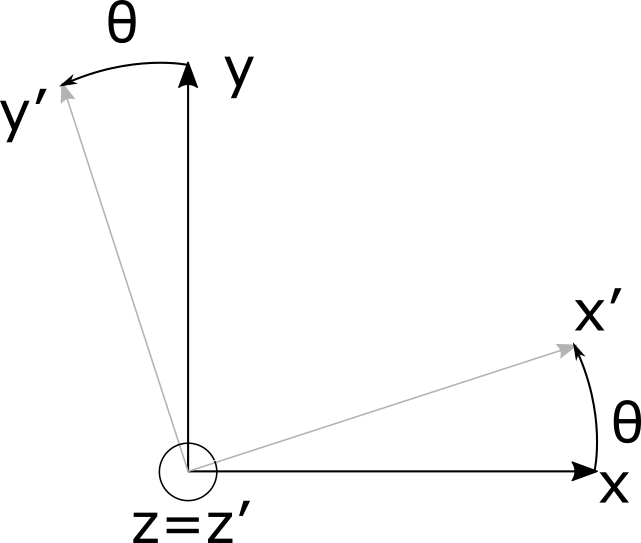

Writing the new basis vectors as $e_x’, e_y’, e_z’$, they can be written as functions of the old basis vectors $e_x, e_y, e_z$:

$$
\left \lbrace
\begin{aligned}
e_x’ = &&\cos \theta e_x + \sin \theta e_y \\
e_y’ = &&-\sin \theta e_x + \cos \theta e_y \\
e_z’ = &&e_z
\end{aligned}
\right.
$$


## Change of basis using the R matrix

Using this formula, we can ask a first question: given the coordinates of a point $v_x e_x’ + v_y e_y’ + v_z e_z’$ in the rotated frame, what are its coordinates in the original frame?

Plugging these in and applying the above equations, we obtain the coordinates that follow:

$$
v_x e_x’ + v_y e_y’ + v_z e_z’ = u_x e_x + u_y e_y + u_z e_z \\
\leftrightarrow
\left \lbrace
\begin{aligned}
u_x = &&\cos \theta v_x - \sin \theta v_y \\
u_y = &&\sin \theta v_x + \cos \theta v_y \\
u_z = &&v_z
\end{aligned}
\right.
$$

This equation can be reformulated using the familiar rotation matrix $R$ into the equation $u = R v$:

$$
R =
\left[ 
\begin{array}{ccc}
\cos \theta & -\sin \theta & 0 \\ 
\sin \theta & \cos \theta & 0 \\ 
0 & 0 & 1
\end{array} 
\right], \quad
u = \left[ 
\begin{array}{c}
u_x \\
u_y \\
u_z
\end{array}
\right]
= R 
\left[ 
\begin{array}{c}
v_x \\
v_y \\
v_z
\end{array}
\right]
= R v
$$

In other words,

> the coordinates of the vector $v$ defined in the rotated basis become the coordinates $u = R v$ in the old basis 

## Inverting the change of basis

The relationship can also be inverted, since rotation by amount $\theta$ is the inverse of rotating by $-\theta$. The inverse of a rotation matrix is its transposed matrix, so we can also write:

> the coordinates of the vector $u$ defined in the old basis become the coordinates $v = \left[ 
\begin{array}{ccc}
\cos \theta & \sin \theta & 0 \\ 
-\sin \theta & \cos \theta & 0 \\ 
0 & 0 & 1
\end{array} 
\right]v = R^\top u$ in the rotated basis 

It should be noted that although we are talking about rotations, the vectors themselves don’t move, only the frames in which we assign them coordinates. This is usually called a **passive** rotation, as opposed to the **active** interpretation of the the same equation. The passive interpretation of the rotation matrix really is an interpretation as a change of coordinate frame, without anything moving.

## The active interpretation

Where things get hairy for me is that the very same rotation matrix can be used to represent an active rotation, with a moving object but fixed coordinate frames: in that case, the matrix $R$ is a way to compute the changed coordinates of an object after it hase been rotated.

> a vector $u’$ defined in the old basis gets rotated and becomes $v’ = R u’$ still in the old basis

This is also interesting, but notice how in that case $u’$ and $v’$ have switched sides when compared with the first formula I gave! 

This is definitely a pain point when working with rotation matrices: the matrix doesn’t encode the full information.
Knowing on which side the matrix $R$ appears is not enough, you need to know what the vectors on each side stand for, which is either coordinates in different frames (passive interpretation) or coordinates in the same frame (active interpretation).



# Putting it all together: Euler angles and the Bunge convention

Enough theory! Let’s apply our newfound knowledge. Above, we only discussed a single rotation. In general, we can reach any orientation in 3D space by chaining three rotations around different axes.
In my particular field, material science, the way to go is (proper) Euler angles, which are understood to be a triplet of axes around which an object is rotated, two axes being repeated, for example ZXZ. 

In particular, the Bunge Euler angle convention used in material science is:

- rotate around axis Z by angle $\varphi_1 \in [0, 2\pi]$
- rotate around axis X’ by angle $\Phi \in [0, \pi]$
- rotate around axis Z’’ by angle $\varphi_2 \in [0, 2\pi]$

Let’ implement this! 

In addition to the rotation matrix R around Z, we need a rotation matrix around X, which can be derived easily. Let’s code the matrices using sympy and display them:

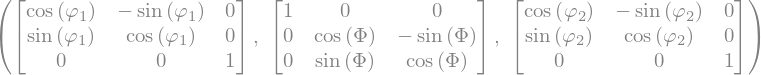

In [1]:
import sympy as sp
sp.init_printing()

phi1, Phi, phi2 = sp.symbols('varphi_1 Phi varphi_2')
#phi1, Phi, phi2 = sp.symbols('varphi theta psi')

R_phi1 = sp.Matrix([[sp.cos(phi1), -sp.sin(phi1), 0],
                    [sp.sin(phi1), sp.cos(phi1), 0],
                    [0, 0, 1]])

R_Phi = sp.Matrix([[1, 0, 0],
                   [0, sp.cos(Phi), -sp.sin(Phi)],
                   [0, sp.sin(Phi), sp.cos(Phi)]])

R_phi2 = sp.Matrix([[sp.cos(phi2), -sp.sin(phi2), 0],
                    [sp.sin(phi2), sp.cos(phi2), 0],
                    [0, 0, 1]])

R_phi1, R_Phi, R_phi2 

Using the matrices we have just defined, we can formulate a global rotation matrix that, when we multiply a point in 3D space with it, gives us its rotated coordinates in the fixed axis system (notice the primes in the formula below, the same notation as in the theory section): 

$$
v’ = R_{\varphi_2} R_{\Phi} R_{\varphi_1} u’
$$

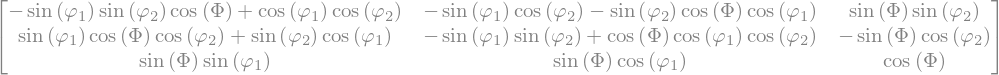

In [2]:
rot_matrix = R_phi2 * R_Phi * R_phi1

rot_matrix

This expression compares favorably with the one in the textbooks. Yay! 

Notice also how the order of matrix operations is reversed with respect to the angle triplet $(\varphi_1, \Phi, \varphi_2)$. This is due to the fact that we right-multiply vectors with this matrix to rotate them, see below.

# Active rotations in a fixed coordinate frame

Let’s now use the matrix above to rotate some objects. As said above, the general formula is:

$$
v’ = R_{\varphi_2} R_{\Phi} R_{\varphi_1} u’,
$$

where $u’$ is a vector holding the coordinates of a point and $v’$ are its rotated coordinates, in the same coordinate system. Let’s use pyvista to animate the rotation of an object in a rotation around Z.

In [3]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# convert the rotation matrix so that it can be used with numpy
rot_matrix_numpy = sp.lambdify([phi1, Phi, phi2], rot_matrix)

# double-check our result using scipy
rot_matrix_scipy = lambda phi1, Phi, phi2: R.from_euler('zxz', [phi1, Phi, phi2], degrees=False).as_matrix()

np.allclose(rot_matrix_numpy(1, 2, 3), rot_matrix_scipy(1, 2, 3))

True

In [4]:
from IPython.display import Video
import tempfile
import pyvista as pv
from pyvista import examples

obj = examples.download_teapot().rotate_x(90, inplace=True)
p0 = obj.points.copy()
p = pv.Plotter()
f = tempfile.NamedTemporaryFile(delete=False, suffix='.mp4')
p.open_movie(f.name)
p.add_mesh(obj, style='wireframe')
p.show(interactive=True, auto_close=False, jupyter_backend="none")
for i in range(51):
    alpha = 2 * np.pi * i / 50
    p.add_title(f"phi_1: {np.rad2deg(alpha):.2f}°")
    obj.points = np.array([np.dot(rot_matrix_numpy(alpha, 0, 0),  p) for p in p0])
    p.write_frame()
p.close()

v = Video(f.name, embed=True)
f.close()

v

Nice, a rotating teapot! 

Let’s now move on to a more complicated sequence, inspired by the wikipedia example shown above. We will interpolate the angles of rotation to get a smooth animation.

In [5]:
from scipy.interpolate import interp1d

phi1_max = np.deg2rad(60.)
Phi_max = np.deg2rad(60.)
phi2_max = np.deg2rad(60.)
seq = np.array([(0, 0, 0, 0),
                (50, phi1_max, 0, 0),
                (100, phi1_max, Phi_max, 0),
                (150, phi1_max, Phi_max, phi2_max)])

n_frames = 60
interped = interp1d(seq[:, 0], seq[:, 1:], axis=0)(np.linspace(0, 150, n_frames).astype(int))


arrow1 = pv.Arrow().scale([0.5, 0.5, 0.5], inplace=True)
arrow2 = pv.Arrow().scale([0.5, 0.5, 0.5], inplace=True).rotate_z(90, inplace=True)
arrow3 = pv.Arrow().scale([0.5, 0.5, 0.5], inplace=True).rotate_z(90, inplace=True).rotate_x(90, inplace=True)
frame = arrow1 + arrow2 + arrow3

obj = examples.download_bunny_coarse().scale([3, 3, 3], inplace=True).rotate_x(90, inplace=True).rotate_z(180, inplace=True)
obj.points -= [0, 0, obj.points[:, 2].min()]
obj = obj +  frame

p0 = obj.points.copy()
p = pv.Plotter()
f = tempfile.NamedTemporaryFile(delete=False, suffix='.mp4')
p.open_movie(f.name, framerate=20)
p.add_mesh(obj, style='wireframe')
p.show(interactive=True, auto_close=False, jupyter_backend="none")
for i in range(n_frames):
    p1, P, p2 = interped[i]
    p.add_title(f"phi_1: {np.rad2deg(p1):.1f}, Phi: {np.rad2deg(P):.1f}, phi_2: {np.rad2deg(p2):.1f}")
    obj.points = np.array([np.dot(rot_matrix_numpy(p1, P, p2),  p) for p in p0])
    p.write_frame()
p.close()

v = Video(f.name, embed=True)
f.close()

v

As one may notice in the animation above, the matrix we derived is actually a rotation based on fixed frame axes, not moving ones like in the example from wikipedia that I quoted.

Let’s now get to the part where the bunny rotates about its own axes.

# Rotations around moving coordinate systems (intrinsic)

The thing we are still missing is that we want to rotate around axes that have changed too. To do that, we actually need to mix rotations and changes of bases.

For instance, rotating points around z gives the following in the old coordinate system $v’ = R_{\varphi_1} u’$.

What would the coordinates of $v’$ be in the need rotated coordinate system? 

The answer: $v’ (R) = R_{\varphi_1}^\top R_{\varphi_1} u’ = u’$. 

Come to think of it, this makes sense: even though we rotated the object, the coordinate frame is glued to it, so a point keeps the same coordinates in the rotated system. Going further with matrices $R_{\Phi}$ and $R_{\varphi_2}$, the coordinates of the rotated object become:

$$
v’(\text{frame T}) = R_{\varphi_2} ^\top R_{\varphi_2}   R_{\Phi}^\top R_{\Phi}  R_{\varphi_1} ^\top R_{\varphi_1} u’ = u’
$$

Surprise: the coordinates in the last rotated frames are identical to the starting coordinates! However, we now want them back in the original frame, so we have to apply the rotation to previous frames:

$$
u’ \rightarrow  R_{\varphi_2} u \rightarrow R_{\Phi} R_{\varphi_2} u \rightarrow R_{\varphi_1} R_{\Phi} R_{\varphi_2} u
$$

We end up with

$$
v’ = R_{\varphi_1} R_{\Phi} R_{\varphi_2} u’,
$$

where $u’$ are the starting coordinates of the object in the rotating z-x’-z’’ frame and $v’$ are the coordinates of the same point in the fixed coordinate system.

In the rotating system, the order of multiplications is reversed compared to the fixed axes system!

Let’s print the obtained matrix.

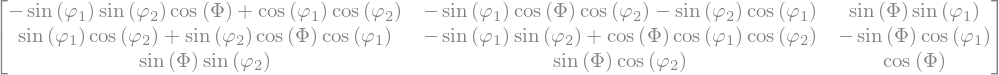

In [6]:
rot_matrix_intrinsic = R_phi1 * R_Phi * R_phi2

rot_matrix_intrinsic

Interestingly, $\varphi_1$ and $\varphi_2$ play symmetric roles in thi intrinsic rotation!

In [7]:
rot_matrix_intrinsic_numpy = sp.lambdify([phi1, Phi, phi2], rot_matrix_intrinsic)

# double-check with scipy
rot_matrix_intrinsic_scipy = lambda phi1, Phi, phi2: R.from_euler('ZXZ', [phi1, Phi, phi2], degrees=False).as_matrix()

np.allclose(rot_matrix_intrinsic_numpy(1, 2, 3), rot_matrix_intrinsic_scipy(1, 2, 3))

True

Let’s now put this into practice and make the animation we started discussing at the start of this post:

In [9]:
from scipy.interpolate import interp1d

phi1_max = np.deg2rad(60.)
Phi_max = np.deg2rad(60.)
phi2_max = np.deg2rad(60.)
seq = np.array([(0, 0, 0, 0),
                (50, phi1_max, 0, 0),
                (100, phi1_max, Phi_max, 0),
                (150, phi1_max, Phi_max, phi2_max)])

n_frames = 60
interped = interp1d(seq[:, 0], seq[:, 1:], axis=0)(np.linspace(0, 150, n_frames).astype(int))

arrow1 = pv.Arrow().scale([0.5, 0.5, 0.5], inplace=True)
arrow2 = pv.Arrow().scale([0.5, 0.5, 0.5], inplace=True).rotate_z(90, inplace=True)
arrow3 = pv.Arrow().scale([0.5, 0.5, 0.5], inplace=True).rotate_z(90, inplace=True).rotate_x(90, inplace=True)
frame = arrow1 + arrow2 + arrow3

obj = examples.download_bunny_coarse().scale([3, 3, 3], inplace=True).rotate_x(90, inplace=True).rotate_z(180, inplace=True)
obj.points -= [0, 0, obj.points[:, 2].min()]
obj = obj +  frame

p0 = obj.points.copy()
p = pv.Plotter()
f = tempfile.NamedTemporaryFile(delete=False, suffix='.mp4')
p.open_movie(f.name, framerate=20)
p.add_mesh(obj, style='wireframe')
p.show(interactive=True, auto_close=False, jupyter_backend="none")
for i in range(n_frames):
    p1, P, p2 = interped[i]
    p.add_title(f"phi_1: {np.rad2deg(p1):.1f}, Phi: {np.rad2deg(P):.1f}, phi_2: {np.rad2deg(p2):.1f}")
    obj.points = np.array([np.dot(rot_matrix_intrinsic_numpy(p1, P, p2),  p) for p in p0])
    p.write_frame()
p.close()

v = Video(f.name, embed=True)
f.close()

v

Yay, we have replicated the Wikipedia animation!

# TL;DR 

$$
R =
\left[ 
\begin{array}{ccc}
\cos \theta & -\sin \theta & 0 \\ 
\sin \theta & \cos \theta & 0 \\ 
0 & 0 & 1
\end{array} 
\right]
$$

Specifying that you are doing a rotation using the matrix $R$ alone is ambiguous. 
An unambiguous way to use $R$ is to write $u = R v$ and to define the meaning of $u$ and $v$.

- case 1 (change of basis, **passive**): $v$ are coordinates in the rotated frame and $u$ are coordinates in the fixed frame
- case 2 (moving object, **active**): $v$ are the coordinates of the object before it moved and $u$ after it moved, *both in the same fixed frame*

This leads to different rotation formulas depending if you are rotating with respect to the fixed frame zxz: 
$$
v’ = R_{\varphi_2} R_{\Phi} R_{\varphi_1} u’.
$$

Or if you’re rotating in the intrinsic coordinate frame Z X’ Z’’ :

$$
v’ = R_{\varphi_1} R_{\Phi} R_{\varphi_2} u’.
$$

As a side note, these rotations can easily be coded using [scipy.spatial.transform.Rotation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html#scipy.spatial.transform.Rotation).

## Further reading

There are a couple of good resources on these topics:

Lan, B. (2015). A Brief Guide to the Fundamentals of Passive and Active Rotations in Material Science. doi:10.13140/RG.2.1.3750.8969

Poppe, M. (n.d.). Euler angles, Mauricio Poppe’s notes, Available: https://www.mauriciopoppe.com/notes/computer-graphics/transformation-matrices/rotation/euler-angles/, (date last viewed: 04-Apr-22). Retrieved April 4, 2022, from https://www.mauriciopoppe.com/notes/computer-graphics/transformation-matrices/rotation/euler-angles/

Rowenhorst, D., Rollett, A. D., Rohrer, G. S., Groeber, M., Jackson, M., Konijnenberg, P. J., and Graef, M. D. (2015). “Consistent representations of and conversions between 3D rotations,” Modelling Simul. Mater. Sci. Eng., 23, 083501. doi:10.1088/0965-0393/23/8/083501

SymPhys (2020). 28. Active/Passive Rotation Matrix Combination. Retrieved from https://www.youtube.com/watch?v=lWrN1iC00F8


*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20220502_eulerAnglesBungeConvention.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20220502_eulerAnglesBungeConvention.ipynb).*